In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

from utils.common import timestampToDate, plotCandles, strTimeToTimestamp, set_date_axis

# Load Data

In [2]:
ohlc = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\dataCleaned\\poloniex\\5min\\USDT_BTC_5min_2016-01-01_2017-12-31.tsv', sep='\t')\
    .query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)

In [3]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc['timestamp'] = usdtBtc.date.apply(strTimeToTimestamp).astype(int)

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain[['close']])
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest[['close']])
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

# Explore

In [4]:
%matplotlib notebook

In [16]:
usdtBtcR.columns

Index(['date', 'close', 'return', 'return_1', 'return_2', 'zscore_36_return',
       'zscore_288_return', 'pma36', 'ma_12_108', 'ma_36_288', 'ac36', 'ac288',
       'zscore_36_volume', 'zscore_288_volume', 'zscore_2016_volume', 'vol36',
       'vol288', 'vol2016', 'dv_36_288', 'timestamp'],
      dtype='object')

In [47]:
p1 = 13495.7827
p2 = 14270
amount = 100
fee = 0.0025

bought = (p1 * amount) * (1 - fee)


0.050367350765065384

In [43]:
usdtBtcR.iloc[190:, :]

,date,close,return,return_1,return_2,zscore_36_return,zscore_288_return,pma36,ma_12_108,ma_36_288,ac36,ac288,zscore_36_volume,zscore_288_volume,zscore_2016_volume,vol36,vol288,vol2016,dv_36_288,timestamp
104158,2017-12-28 15:50:00,"14,159.0000",0.0114,0.0065,-0.0022,1.8418,1.6399,1.4475,0.9264,0.9264,1.0635,-1.5012,2.0193,0.3449,0.0857,-0.4208,1.3404,1.6152,1.2953,1514472600
104159,2017-12-28 15:55:00,"14,120.0000",-0.0028,0.0114,0.0065,-0.6475,-0.3520,1.2616,0.9477,0.9477,1.1255,-1.4923,0.0091,-0.2862,-0.3441,-0.5384,1.3329,1.5930,1.2875,1514472900
104160,2017-12-28 16:00:00,"14,300.0000",0.0127,-0.0028,0.0114,2.0694,1.8112,1.8230,1.0361,1.0361,1.2260,-1.4806,5.6975,1.4478,0.8349,-0.4584,1.3378,1.6356,1.2918,1514473200
104161,2017-12-28 16:05:00,"14,325.0000",0.0017,0.0127,-0.0028,0.0735,0.2658,1.8294,1.1605,1.1605,1.3216,-1.4688,0.7562,0.0633,-0.1071,-0.4620,1.3302,1.5875,1.2840,1514473500
104162,2017-12-28 16:10:00,"14,270.0000",-0.0038,0.0017,0.0127,-0.8686,-0.5122,1.5502,1.2879,1.2879,1.4170,-1.4577,0.3055,-0.0997,-0.2220,-0.5291,1.3249,1.4816,1.2783,1514473800
104163,2017-12-28 16:15:00,"14,240.0000",-0.0021,-0.0038,0.0017,-0.6052,-0.2681,1.3658,1.3664,1.3664,1.5006,-1.4477,2.3592,0.7659,0.3666,-0.5206,1.3094,1.4552,1.2628,1514474100
104164,2017-12-28 16:20:00,"14,200.0000",-0.0028,-0.0021,-0.0038,-0.7143,-0.3630,1.1539,1.4295,1.4295,1.5690,-1.4382,1.0773,0.2860,0.0420,-0.5025,1.3026,1.3919,1.2558,1514474400
104165,2017-12-28 16:25:00,"14,287.5734",0.0062,-0.0028,-0.0021,0.8289,0.8886,1.3924,1.4829,1.4829,1.6248,-1.4290,-0.5735,-0.4474,-0.4564,-0.5593,1.2893,1.3929,1.2424,1514474700
104166,2017-12-28 16:30:00,"14,150.0000",-0.0096,0.0062,-0.0028,-1.8643,-1.3106,0.8536,1.5170,1.5170,1.6635,-1.4206,-0.2094,-0.2838,-0.3455,-0.4624,1.3015,0.7973,1.2541,1514475000
104167,2017-12-28 16:35:00,"14,111.0000",-0.0028,-0.0096,0.0062,-0.6380,-0.3488,0.6731,1.5418,1.5418,1.6795,-1.4119,0.2330,-0.0710,-0.2005,-0.4721,1.2883,0.7822,1.2410,1514475300


<IPython.core.display.Javascript object>


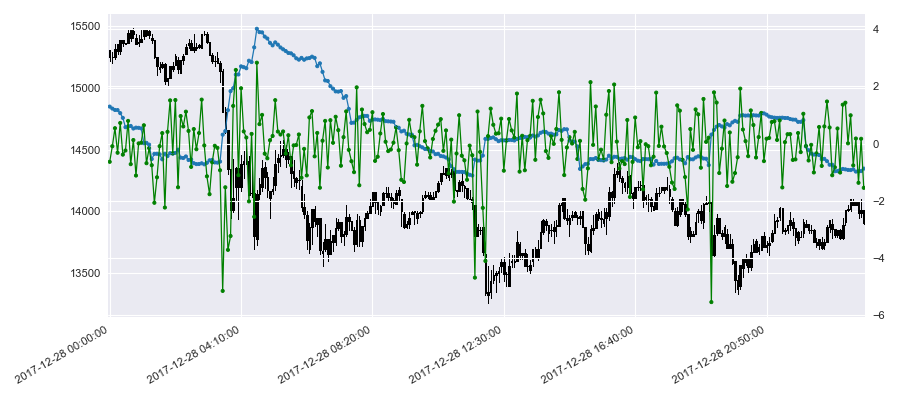

In [64]:
step = 361
day = 288
i = day * step
j = i + day
usdtBtcR = usdtBtc.iloc[i:j, :]

paper_rc = {'lines.linewidth': 0.5, 'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc) 

fig, ax = plotCandles(ohlc.iloc[i:j, :])
ax2 = ax.twinx()
sns.pointplot(usdtBtcR.timestamp.values, usdtBtcR['vol36'].values, ax=ax2)
sns.pointplot(usdtBtcR.timestamp.values, usdtBtcR['zscore_36_return'].values, ax=ax2, color='green')

set_date_axis(usdtBtcR['timestamp'], ax, fig)

# Implementation

In [59]:
from copy import deepcopy

class DistanceFromMaxStrategy:
    def __init__(self, exchange, dataManager, historyLen, contractPair, tradeSize, willingLoss, 
                 distanceFromMaxThreshold, targetProfit):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.historyLen = historyLen
        self.contractPair = contractPair
        self.opened = False
        self.tradeSize = tradeSize
        self.willingLoss = willingLoss
        self.distanceFromMaxThreshold = distanceFromMaxThreshold
        self.targetProfit = targetProfit
    
    
    def isRisky(self, priceBought, actualPrice):
        return self.currentReturn(priceBought, actualPrice) < -self.willingLoss 
    
    
    def currentReturn(self, priceBought, actualPrice):
        return float(actualPrice - priceBought) / priceBought
    
    
    def sellWhole(self, price):
        self.opened = False
        amount = self.exchange.balance(self.contractPair['tradeContract'])
        self.exchange.sell(self.contractPair, amount, price)
    
    
    def buy(self, price):
        amount = self.tradeSize / price
        self.exchange.buy(self.contractPair, amount, price)
        self.opened = True
        
        fee = self.exchange.fee
        breakEvenPrice = price + price * fee * 2 + price * (fee ** 2)
        return breakEvenPrice
        
    
    def isTargetSatisffied(self, priceBought, price):
        return self.currentReturn(priceBought, price) >= self.targetProfit
    
    
    def currentTime(self):
        return self.dataManager.time
    
    def timeExceeded(self, timeBought):
        return (self.currentTime() - timeBought) > self.historyLen
    
    def trade(self):
        
        wasBellow = False
        while self.dataManager.has_tick():            
            history, price = self.dataManager.tick(self.historyLen)
            if history.shape[0] < self.historyLen:
                continue

            closeMax = history[0].max()
            distanceFromMax = (closeMax / price) - 1
#             print(history.shape[0], distanceFromMax, closeMax, price)
            if not self.opened and distanceFromMax >= self.distanceFromMaxThreshold:
#                 print(self.dataManager.time, 'openning trade: ', price, end='\t')
                breakEvenPrice = self.buy(price)
                priceBought = price
                timeBought = self.currentTime()
            elif self.opened and (self.isRisky(priceBought, price) or self.timeExceeded(timeBought)):
#                 print(self.dataManager.time, 'stopLoss: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)
            elif self.opened and self.isTargetSatisffied(breakEvenPrice, price):
#                 print(self.dataManager.time, 'profit: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)

                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)

# Learning

In [63]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = DistanceFromMaxStrategy(exchange, dataManager, 1*288, contractPair, 100, willingLoss=0.1, 
                                   distanceFromMaxThreshold=0.05, targetProfit=0.01)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,171.0000
totalProfit,-6.7400
avgProfit,-0.0394
winPercentage,82.4561
avgWinTrade,1.4991
avgLossTrade,-7.2703
profitFactor,0.9691
maxDrawdown,4.5841


In [ ]:
import time, sys
DAY = 288

allStats = None
for historyLen in [DAY, 2*DAY, 3*DAY, 5*DAY]:
    for willingLoss in [.01, .03, .05, .1, .2, .5]:
        for distanceFromMaxThreshold in [.01, .02, .05, .07, .1, .2]:
            for targetProfit in [.01, .02, .05, .07, .1, .2, .3]:
                print('historyLen:', historyLen, end='\t')
                print('willingLoss', willingLoss, end='\t')
                print('distanceFromMaxThreshold', distanceFromMaxThreshold, end='\t')
                print('targetProfit', targetProfit, end='\t')
                sys.stdout.flush()
                
                start_time = time.time()
                dataManager = deepcopy(usdtBtcManagerTrain)
                exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
                strategy = DistanceFromMaxStrategy(exchange, dataManager, historyLen, contractPair, 100, willingLoss=willingLoss, 
                                   distanceFromMaxThreshold=distanceFromMaxThreshold, targetProfit=targetProfit)
                strategy.trade()
                stats = strategy.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
                stats['historyLen'] = historyLen
                stats['willingLoss'] = willingLoss
                stats['distanceFromMaxThreshold'] = distanceFromMaxThreshold
                stats['targetProfit'] = targetProfit
                if allStats is None:
                    allStats = stats
                else:
                    allStats = allStats.append(stats)
                print("%.2f seconds" % (time.time() - start_time))

allStats.to_csv('D:\\Dropbox\\My work\\krypl-project\\result\\distanceFromMaxWithTimeRestriction.tsv', index=False, sep='\t')

# Look on transactions

In [ ]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

import time
import datetime as dt

def timestampToDate(timestamp):
    return dt.datetime.fromtimestamp(int(timestamp))

def strTimeToTimestamp(strTime):
    return dt.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S").timestamp()


def calculateMA(history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})


def plotCandles(df, currencyPair):
    DATA = df[['open', 'high', 'low', 'close', 'volume', 'date', 'timestamp']].copy()
    DATA = DATA.reset_index()
    DATA["dateStr"] = DATA["date"]
    DATA["date"]  = DATA["timestamp"].apply(timestampToDate).apply(mdates.date2num)

    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    candlestick_ohlc(ax, DATA.values, width=.6, colorup='#53c156', colordown='#ff1717')

    ax.xaxis_date()
    
    xDates = DATA['dateStr']
    step = int(xDates.shape[0] / 20) + 1
    xDates[[i for i in range(xDates.shape[0]) if i % step != 0]] = ''
    
    plt.xticks(range(DATA.shape[0]), DATA['dateStr'], rotation=45)
    plt.title(currencyPair, fontproperties=titleFont)
    

def plotTransaction(transaction, i):
    color = 'k' if type(transaction) == BuyTransaction else 'm'
    plt.scatter(i, transaction.price.value, s=200, c=color)
    

def plotMax(mmax, i):
    plt.scatter(i, mmax, s=200, c='b')

    
def indexRange(i, offsetBack, offsetForward, length):
    start = i - offsetBack if i - offsetBack > 0 else 0
    end = i + offsetForward if i + offsetForward < length else length-1
    return start, end
    
def plotTransactionWithSurroundings(prices, timePeriod, transaction):
    i = transaction.timestamp
    start,end = indexRange(i, 40, 20, prices.shape[0])
    selected = prices.iloc[start:end, :].reset_index()
    
    plotCandles(selected, '')
    plotTransaction(transaction, 39)
    
    mmax = prices.iloc[start:i, :]['close'].max()
    plotMax(mmax, 39)
    

In [ ]:
len(strategy.exchange.transactions)

In [ ]:
t = 506

transaction = strategy.exchange.transactions[t]
plotTransactionWithSurroundings(usdtBtcTrain, strategy.historyLen, transaction)
transaction = strategy.exchange.transactions[t+1]
plotTransactionWithSurroundings(usdtBtcTrain, strategy.historyLen, transaction)

In [ ]:
transaction

# Evaluate Distance From Max

In [ ]:
allStats = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\result\\distanceFromMaxWithTimeRestriction.tsv',sep='\t')

In [ ]:
allStats.query('totalProfit > 90 and winPercentage > 70').sort_values('numberOfTrades', ascending=False)

In [ ]:
dataManager = deepcopy(usdtBtcManagerTest)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = BollingerBandsStrategy(exchange, dataManager, 30, contractPair, 100, willingLoss=0.03, distFromMiddleThreshold=0.02, diffThreshold=0.01)
strategy.trade()
strategy.stats('usdt').report()